In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import fcnoutlier as fno

%matplotlib inline

In [12]:
# LOF has no fit and predict so one has to update the get_test function and the get_model function
# furthermore the calculation takes very long, so maybe not the best method to use

# Utils

In [10]:
def plot_hist(df):
    # plot hist over relKa
    fig = plt.figure(figsize=(10,10))
    df['Label'].hist(bins = 100)
    plt.title('Histogram over relKa',fontsize=16)
    plt.xlabel('relKa')

def get_info(df):
    # get info above the data how many points are above a relKa threshold
    tmp = list(np.linspace(0,1,11))
    for num in tmp:
        print('# datapoints {:.2f} above {}'.format(num,df[df['Label'] > num].shape[0]))

def get_class(df,thres=0.7,delte=True):
    # convert relKa in classes 0 : inlier 1: outlier
    df['Class'] = 0
    df.loc[df['Label']>=thres,'Class'] = 1
    if delte:
        df.drop(['Label'],axis=1,inplace=True)
        return
    return df

def get_normal(df,num1=0,num2=-1):
    # normalize the data
    data_sc = pd.DataFrame(StandardScaler().fit_transform(df.loc[:,df.columns[num1:num2]]))
    data_sc['Class'] = df['Class']
    return data_sc

def get_testdata(df):
    # create train_data, test_data , test_class, only outlier
    tfbs = df[df.Class == 1]
    ntfbs = df[df.Class == 0]
    #shuffeled_data = non_tfbs.sample(frac=1, random_state=42)
    # prepare df_train
    train = ntfbs.sample(frac=0.8, random_state = 42)
    train.drop(['Class'],axis=1,inplace=True)
    
    tmp = ntfbs.loc[list(set(ntfbs.index)-set(train.index)),:]
    test = pd.concat([tmp,pd.DataFrame(tfbs)])
    test_class = test.loc[:,'Class'].copy()
    test.drop(['Class'],axis = 1,inplace=True)
    tfbs.drop(['Class'],axis=1, inplace=True)
    
    # return train set, test set, test class, df[Class==1]
    return train, test, test_class, tfbs

def get_prec(df):
    # get the contermination in the dataset
    return (df[df['Class']==1].shape[0]/df.shape[0])

def get_labels(y):
    # encode labels in the correct way 0: inlier 1: outlier
    tmp = np.zeros((y.shape[0]))
    tmp[y == -1] = 1
    return tmp

def get_model(X,n_ngbh=20,perc=0.1):
    # create model and try it on train data
    lof = LocalOutlierFactor(n_neighbors=n_ngbh, contamination = perc).fit(X) 
    return lof

def get_eval(model,X,y_truth):
    # evaluate the model, predict on test data and calculate the error
    y_pred = model.predict(X)
    n_errors = (get_labels(y_pred) != y_truth).sum()
    #print('Number of Errors {}'.format(n_errors))
    return y_pred, n_errors

def get_f1(train,test,perc,y_truth):
    # optimizer parameter of the model
    min_es = 10
    max_es = 30
    f1 = []

    for n in np.arange(min_es, max_es, 2):
        lof = get_model(train, n_ngbh=n, perc=perc)
        y_pred, n_error = get_eval(lof,test,y_truth)
    
        y_pred = get_lables(y_pred)
        precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_truth, y_pred, average='binary')
    
        print("F1 score on test", round(fbeta_score,4), " with support_fraction ", sf)
        f1.append([sf, round(fbeta_score,4)])
    
    df1 = pd.DataFrame(EpsF1, columns = ['sf', 'f1'])
    return df1

# Lof for Groundstate

# datapoints 0.00 above 68976
# datapoints 0.10 above 68976
# datapoints 0.20 above 67734
# datapoints 0.30 above 41532
# datapoints 0.40 above 17193
# datapoints 0.50 above 7264
# datapoints 0.60 above 2942
# datapoints 0.70 above 1128
# datapoints 0.80 above 354
# datapoints 0.90 above 86
# datapoints 1.00 above 0


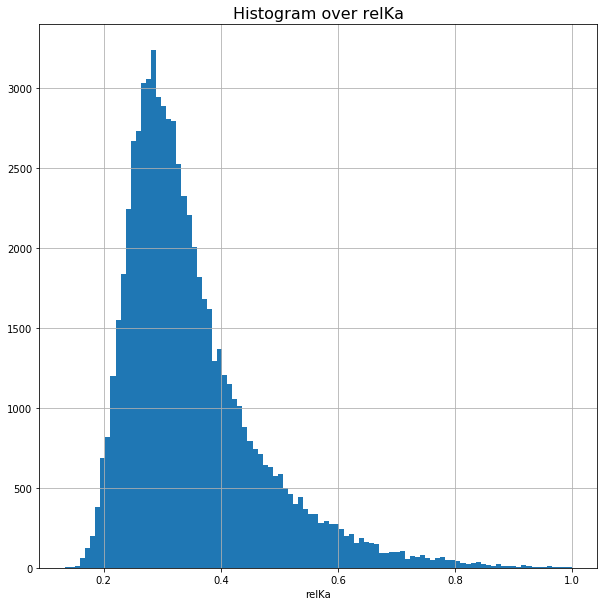

In [6]:
data = pd.read_csv('../data/groundstate/GSM1586782_ScrWT_Exd_14mer_cg_gs.txt')
fno.plot_hist(data)
fno.get_info(data)

In [7]:
fno.get_class(data)
data_sc = fno.get_normal(data)
train_data, test_data, y_test, tfbs = fno.get_testdata(data_sc)
perc = fno.get_prec(data_sc)

/home/jate1/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
lof = fno.get_model(train_data,perc=perc)
y_pred, n_errors = fno.get_eval(lof,test_data,y_test)
data.loc[test_data[y_pred == -1].index,'Class']
fno.confusion_matrix(fno.get_labels(y_pred),y_test)

AttributeError: predict is not available when novelty=False, use fit_predict if you want to predict on training data. Use novelty=True if you want to use LOF for novelty detection and predict on new unseen data.

# Lof for stiffness

In [ ]:
data = pd.read_csv('../data/stiffness/GSM1586782_ScrWT_Exd_14mer_cg_gs.txt')
fno.plot_hist(data)
fno.get_info(data)

In [ ]:
# encode class
fno.get_class(data)
# normalize data
data_sc=fno.get_normal(data)
# split data
train_data, test_data, y_test, tfbs = fno.get_testdata(data_sc)
# cal contermination
perc = fno.get_prec(data_sc)
# get trained model
lof = fno.get_model(train_data,perc=perc)
# evaluate the model
y_pred, n_errors = fno.get_eval(lof,test_data,y_test)
# look at the prediction 
data.loc[test_data[y_pred == -1].index,'Class']
# calculate confusion matrix
fno.confusion_matrix(fno.get_labels(y_pred),y_test)

# Lof for GS & stiffness

In [ ]:
data_stiff = pd.read_csv('../data/stiffness/GSM1586782_ScrWT_Exd_14mer_cg_eigs.txt')
data_gs = pd.read_csv('../data/groundstate/GSM1586782_ScrWT_Exd_14mer_cg_gs.txt')
data = pd.concat([data_stiff.loc[:,data_stiff.columns[:-1]],data_gs],axis=1)
data.head()

In [ ]:
# encode class
fno.get_class(data)
# normalize data
data_sc = fno.get_normal(data)
# split data
train_data, test_data, y_test, tfbs = fno.get_testdata(data_sc)
# cal contermination
perc = fno.get_prec(data_sc)
# get trained model
lof = fno.get_model(train_data,perc=perc)
# evaluate the model
y_pred, n_errors = fno.get_eval(lof,test_data,y_test)
# look at the prediction 
data.loc[test_data[y_pred == -1].index,'Class']
# calculate confusion matrix
fno.confusion_matrix(fno.get_labels(y_pred),y_test)